Here’s the final approach I took to solve the problem:

1. Data Loading
I started by loading the training dataset (Assignment_Train.csv), the test dataset (Assignment_Test.csv), and the feature dictionary from an Excel file.
2. Data Cleaning
I checked for missing values in both datasets and used a custom function to clean the APPLICATION LOGIN DATE column by standardizing it to a DD-MM-YYYY format.
For missing numerical values, I applied mean imputation using SimpleImputer to fill in the gaps.
3. Feature Engineering
I extracted additional features like day, month, and year from the APPLICATION LOGIN DATE in both the train and test datasets. Afterward, I dropped the original APPLICATION LOGIN DATE column.
This step helped me generate temporal features that could improve model performance.
4. Data Visualization
To gain insights, I visualized the distribution of the target variable (Application Status), created a correlation heatmap, and examined summary statistics for the numerical columns.
5. Label Encoding for Categorical Variables
Using LabelEncoder, I transformed categorical variables into numerical values for both train and test datasets.
For the test dataset, I made sure to handle unseen categories during encoding to avoid issues during model prediction.
6. Train-Test Split
I split the training data into training and validation sets (80% for training, 20% for validation) to evaluate model performance.
7. Model Building
I trained a RandomForestClassifier with 100 estimators on the training data.
I evaluated the model using accuracy, F1 score, and a classification report on the validation data.
8. Debugging and Handling Mismatched Columns
During prediction, I encountered an issue with mismatched columns between the train and test datasets. To fix this, I added missing columns to the test dataset with default values:
For categorical columns, I used an empty string ('').
For numerical columns, I set the value to 0.
I also removed any extra columns in the test dataset that weren't present in the training dataset to ensure both had the same structure.
9. Prediction and Submission
After resolving the column issues, I predicted the application status on the test data.
I mapped the predicted values to either "APPROVED" (1) or "DECLINED" (0).
Finally, I saved the predictions in a CSV file (predictions.csv), containing two columns: DEALER ID and Application Status.
Final Outcome:
In summary, I handled data cleaning, feature engineering, categorical encoding, and built a Random Forest classifier. I resolved feature mismatches between the train and test datasets, and the final predictions were mapped to "APPROVED"/"DECLINED" statuses and saved for submission.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import re
# Load the datasets
train = pd.read_csv('Assignment_Train.csv')
test = pd.read_csv('Assignment_Test.csv')
feature_dict = pd.read_excel('Assignment_FeatureDictionary.xlsx')

# Step 1: Data Cleaning
# Checking for missing values
print("Missing values in train dataset:\n", train.isnull().sum())
print("Missing values in test dataset:\n", test.isnull().sum())

# Clean the date column as per the previous approach (assuming column name 'APPLICATION LOGIN DATE')
def clean_dates(date):
    if isinstance(date, pd.Timestamp):
        return date  # Leave timestamp as is

    date = str(date).strip()  # Strip any leading/trailing whitespaces

    # Check if date is in MM/DD/YYYY format
    if re.match(r'\d{2}/\d{2}/\d{4}', date):
        return pd.to_datetime(date, format='%m/%d/%Y').strftime('%d-%m-%Y')

    # Check if date is already in DD-MM-YYYY or DD/MM/YYYY format
    if re.match(r'\d{2}-\d{2}-\d{4}', date) or re.match(r'\d{2}/\d{2}/\d{4}', date):
        return pd.to_datetime(date, format='%d-%m-%Y')

    # Coerce and return NaT if invalid date
    return pd.to_datetime(date, errors='coerce').strftime('%d-%m-%Y')

train['APPLICATION LOGIN DATE'] = train['APPLICATION LOGIN DATE'].apply(clean_dates)
test['APPLICATION LOGIN DATE'] = test['APPLICATION LOGIN DATE'].apply(clean_dates)

# Convert back to datetime for further analysis
train['APPLICATION LOGIN DATE'] = pd.to_datetime(train['APPLICATION LOGIN DATE'], format='%d-%m-%Y', errors='coerce')
test['APPLICATION LOGIN DATE'] = pd.to_datetime(test['APPLICATION LOGIN DATE'], format='%d-%m-%Y', errors='coerce')

# Handle missing data
imputer = SimpleImputer(strategy='mean')

# Select only numerical columns for mean imputation
numerical_cols = train.select_dtypes(include=np.number).columns
train[numerical_cols] = imputer.fit_transform(train[numerical_cols])
test[numerical_cols] = imputer.transform(test[numerical_cols])

Missing values in train dataset:
 DEALER ID                                 0
APPLICATION LOGIN DATE                    0
HDB BRANCH NAME                           1
HDB BRANCH STATE                        854
FIRST NAME                                0
MIDDLE NAME                            7145
LAST NAME                               681
mobile                                    0
AADHAR VERIFIED                           0
Cibil Score                            4297
MOBILE VERIFICATION                       0
DEALER NAME                               4
TOTAL ASSET COST                       5108
ASSET CTG                              5108
ASSET MODEL NO                            0
APPLIED AMOUNT                            0
PRIMARY ASSET MAKE                        0
Primary Asset Model No                    0
Personal Email Address                    0
MARITAL STATUS                         4894
GENDER                                    0
DOB                                       

In [5]:
# Step 2: Feature Engineering
# Extract day, month, and year from the 'APPLICATION LOGIN DATE'
train['Day'] = train['APPLICATION LOGIN DATE'].dt.day
train['Month'] = train['APPLICATION LOGIN DATE'].dt.month
train['Year'] = train['APPLICATION LOGIN DATE'].dt.year

test['Day'] = test['APPLICATION LOGIN DATE'].dt.day
test['Month'] = test['APPLICATION LOGIN DATE'].dt.month
test['Year'] = test['APPLICATION LOGIN DATE'].dt.year

# Drop the original 'APPLICATION LOGIN DATE' column
train.drop('APPLICATION LOGIN DATE', axis=1, inplace=True)
test.drop('APPLICATION LOGIN DATE', axis=1, inplace=True)

           DEALER ID  HDB BRANCH NAME  HDB BRANCH STATE    FIRST NAME  \
count   10000.000000      10000.00000      10000.000000  10000.000000   
mean   102936.459100        244.41570         13.859600   2293.895100   
std     37830.984431        145.72909          7.584012   1298.466697   
min     49849.000000          0.00000          0.000000      0.000000   
25%     79953.750000        135.00000          6.000000   1167.000000   
50%     94631.000000        226.00000         15.000000   2316.500000   
75%    108463.000000        355.00000         21.000000   3389.000000   
max    202616.000000        542.00000         24.000000   4462.000000   

        MIDDLE NAME     LAST NAME        mobile  AADHAR VERIFIED  \
count  10000.000000  10000.000000  1.000000e+04          10000.0   
mean    1092.587500   1771.813800  8.630041e+09              0.0   
std      325.130616    931.464362  1.077717e+09              0.0   
min        0.000000      0.000000  6.000042e+09              0.0   
25

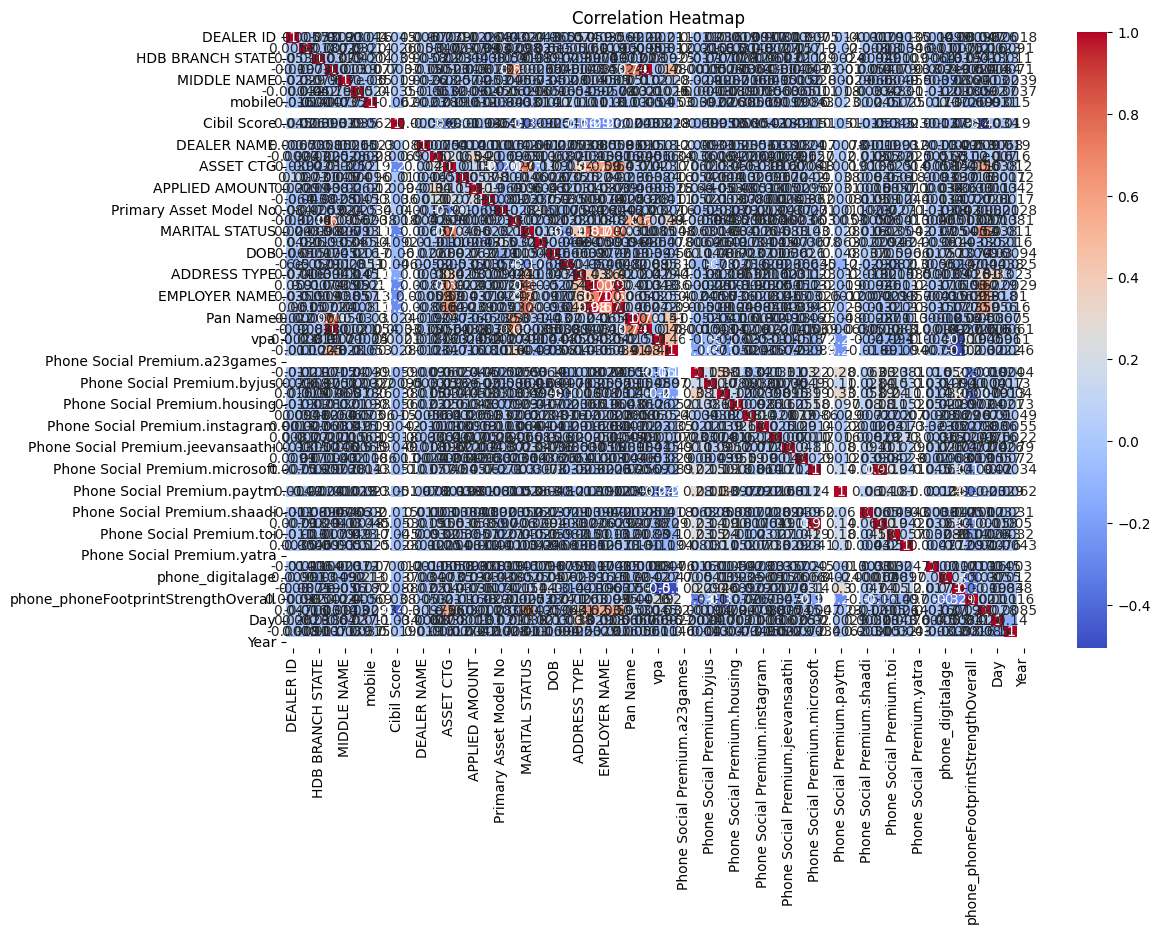

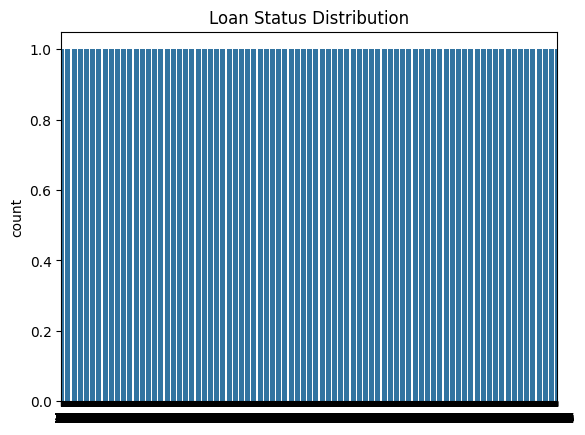

In [13]:
# Step 3: Data Visualization
# Summary statistics for numerical columns
print(train.describe())

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Distribution of target variable (Assuming target variable is 'Loan_Status')
sns.countplot(train['Application Status'])
plt.title('Loan Status Distribution')
plt.show()

In [7]:
# Step 4: Train-Test Split
# Encoding categorical columns
label_encoders = {}
for column in train.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    train[column] = label_encoders[column].fit_transform(train[column])

# Splitting the data into features and target variable
X = train.drop('Application Status', axis=1)  # Changed 'Loan_Status' to 'Application Status'
y = train['Application Status'] # Changed 'Loan_Status' to 'Application Status'

# Train-test split for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 5: Model Building
# Using a Random Forest Classifier as an example
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Step 6: Model Evaluation
y_pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.881
F1 Score: 0.82396449704142
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1327
           1       0.82      0.83      0.82       673

    accuracy                           0.88      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.88      0.88      0.88      2000



In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encoding categorical columns in the train dataset
label_encoders = {}
for column in train.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    train[column] = label_encoders[column].fit_transform(train[column])

# Splitting the data into features and target variable
X = train.drop('Application Status', axis=1)
y = train['Application Status']

# Train-test split for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Using a Random Forest Classifier as an example
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Print target distribution
print("Training data target distribution:")
print(y.value_counts())

# Validation predictions
val_predictions = clf.predict(X_val)
print("Validation predictions distribution:")
print(pd.Series(val_predictions).value_counts())
print("Classification Report for Validation Data:")
print(classification_report(y_val, val_predictions))

# Debugging column names
print("Columns in X_train:", X_train.columns.tolist())
print("Columns in test:", test.columns.tolist())

# Add missing columns with default values
missing_columns = set(X_train.columns) - set(test.columns)
for col in missing_columns:
    print(f"Adding missing column: {col}")
    if col in X_train.select_dtypes(include=['object']).columns:
        test[col] = ''  # Default value for categorical columns
    else:
        test[col] = 0   # Default value for numeric columns

# Remove extra columns in test data
extra_columns = set(test.columns) - set(X_train.columns)
for col in extra_columns:
    print(f"Removing extra column: {col}")
    test.drop(columns=[col], inplace=True)

# Align columns in test data
test_features = test[X_train.columns]

# Ensure no object-type columns are left
# Check for object columns and encode them
for col in test_features.select_dtypes(include=['object']).columns:
    print(f"Encoding column {col}")
    le = LabelEncoder()
    test_features[col] = le.fit_transform(test_features[col])

# Retry prediction
try:
    test_predictions = clf.predict(test_features)
except ValueError as e:
    print(f"Error during prediction: {e}")
    # Debugging information for missing columns
    train_columns = set(X_train.columns)
    test_columns = set(test_features.columns)
    missing_columns = train_columns - test_columns
    print("Missing columns after prediction error:", missing_columns)

    # Add missing columns if any
    for col in missing_columns:
        test_features[col] = 0
    # Retry prediction
    test_predictions = clf.predict(test_features)

# Print sample predictions
print("Sample predictions on test data:")
print(test_predictions[:10])

# Create a mapping for the application status
status_mapping = {
    1: 'APPROVED',
    0: 'DECLINED'
}

# Convert the predictions to 1 for 'APPROVED' and 0 for 'DECLINED'
test_predictions_mapped = [status_mapping.get(pred, pred) for pred in test_predictions]

# Create and save submission DataFrame
submission = pd.DataFrame({
    'DEALER ID': test['DEALER ID'],  # Use 'DEALER ID' as the unique identifier
    'Application Status': test_predictions_mapped  # Mapping predicted values
})
submission.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv'")

Training data target distribution:
Application Status
0    6677
1    3323
Name: count, dtype: int64
Validation predictions distribution:
0    1321
1     679
Name: count, dtype: int64
Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1327
           1       0.82      0.83      0.82       673

    accuracy                           0.88      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.88      0.88      0.88      2000

Columns in X_train: ['DEALER ID', 'HDB BRANCH NAME', 'HDB BRANCH STATE', 'FIRST NAME', 'MIDDLE NAME', 'LAST NAME', 'mobile', 'AADHAR VERIFIED', 'Cibil Score', 'MOBILE VERIFICATION', 'DEALER NAME', 'TOTAL ASSET COST', 'ASSET CTG', 'ASSET MODEL NO', 'APPLIED AMOUNT', 'PRIMARY ASSET MAKE', 'Primary Asset Model No', 'Personal Email Address', 'MARITAL STATUS', 'GENDER', 'DOB', 'AGE', 'ADDRESS TYPE', 'EMPLOY CONSTITUTION', 'EMPLOYER NAME', 'EMPLOYER